In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib  # For saving and loading the model


In [6]:

# 1. Load the dataset
# Replace 'creditcard.csv' with your dataset path if different
try:
    df = pd.read_csv("creditcard.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset file not found. Please check the file path.")
    raise


Dataset loaded successfully.


In [7]:
# 2. Inspect the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())



First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

In [8]:

# 3. Check for the 'abc' column and remove it if exists
if 'abc' in df.columns:
    print("\nColumn 'abc' found. Removing it.")
    df = df.drop(columns=['abc'])
else:
    print("\nColumn 'abc' not found. Proceeding without removing it.")



Column 'abc' not found. Proceeding without removing it.


In [9]:

# 4. Check for missing values
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)

# If there are missing values, decide how to handle them
if missing_values.any():
    print("\nMissing values detected. Handling missing values...")
    # Option 1: Drop rows with any missing values
    df = df.dropna()
    print("Missing values dropped.")

    # Option 2: Alternatively, you can impute missing values
    # Example: Impute with median
    # df.fillna(df.median(), inplace=True)
    # print("Missing values imputed with median.")
else:
    print("No missing values detected.")



Checking for missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
No missing values detected.


In [10]:

# 5. Separate features (V1 to V28, Time, Amount) and target (Class)
X = df.drop(columns=["Class"])
y = df["Class"]

# Verify if 'Class' column has any NaN values
if y.isnull().sum() > 0:
    print("\nTarget variable 'Class' contains NaN values. Handling them...")
    # Option 1: Drop rows where 'Class' is NaN
    df = df.dropna(subset=['Class'])
    X = df.drop(columns=["Class"])
    y = df["Class"]
    print("Rows with NaN in 'Class' dropped.")

    # Option 2: Alternatively, you can impute, but for classification, dropping is usually better
else:
    print("\nNo NaN values in target variable 'Class'.")

# Double-check for any remaining missing values in features
if X.isnull().sum().sum() > 0:
    print("\nFeatures contain missing values. Handling them...")
    # Drop rows with missing values in features
    X = X.dropna()
    y = y[X.index]
    print("Rows with missing feature values dropped.")



No NaN values in target variable 'Class'.


In [11]:

# 6. Standardize the 'Amount' and 'Time' features
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])
X["Time"] = scaler.fit_transform(X[["Time"]])


In [12]:

# 7. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("\nData split into training and testing sets.")



Data split into training and testing sets.


In [13]:

# 8. Handle Imbalanced Data with SMOTE (Synthetic Minority Over-sampling Technique)
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
try:
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("SMOTE applied successfully.")
except ValueError as e:
    print(f"Error applying SMOTE: {e}")
    raise



Applying SMOTE to handle class imbalance...
SMOTE applied successfully.


In [14]:

# 9. Train XGBoost Classifier
print("\nTraining the XGBoost classifier...")
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',  # To avoid warnings
    random_state=42
)
model.fit(X_train_smote, y_train_smote)
print("Model training completed.")



Training the XGBoost classifier...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.


In [15]:
# 10. Model Evaluation
print("\nEvaluating the model on the test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Log Loss (for classification)
loss = log_loss(y_test, y_pred_proba)

# Print Metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Log Loss: {loss:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Evaluating the model on the test set...

Accuracy: 0.9951
F1 Score: 0.3735
Recall: 0.8378
Precision: 0.2403
Log Loss: 0.0210

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.24      0.84      0.37       148

    accuracy                           1.00     85443
   macro avg       0.62      0.92      0.69     85443
weighted avg       1.00      1.00      1.00     85443


Confusion Matrix:
 [[84903   392]
 [   24   124]]


In [16]:

# 11. Save the trained model
model_filename = "fraud_detection_model.pkl"
joblib.dump(model, model_filename)
print(f"\nModel saved as '{model_filename}'")



Model saved as 'fraud_detection_model.pkl'


In [17]:

# 12. Load and Test the Saved Model
print("\nLoading the saved model for verification...")
loaded_model = joblib.load(model_filename)
loaded_y_pred = loaded_model.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_y_pred)
print(f"Loaded Model Accuracy: {loaded_accuracy:.4f}")



Loading the saved model for verification...
Loaded Model Accuracy: 0.9951


<ipython-input-18-db9976fe05e1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


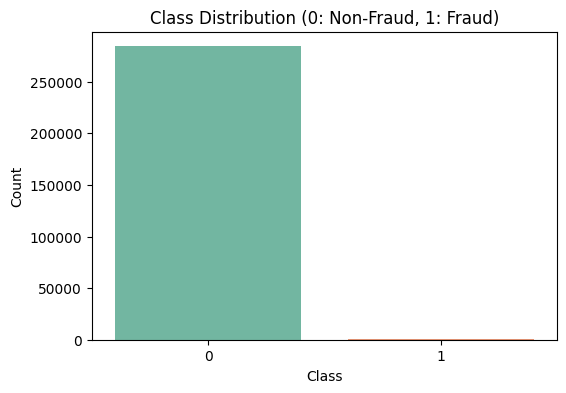

In [18]:

# 13. Graphical Representation of the Dataset

# a. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


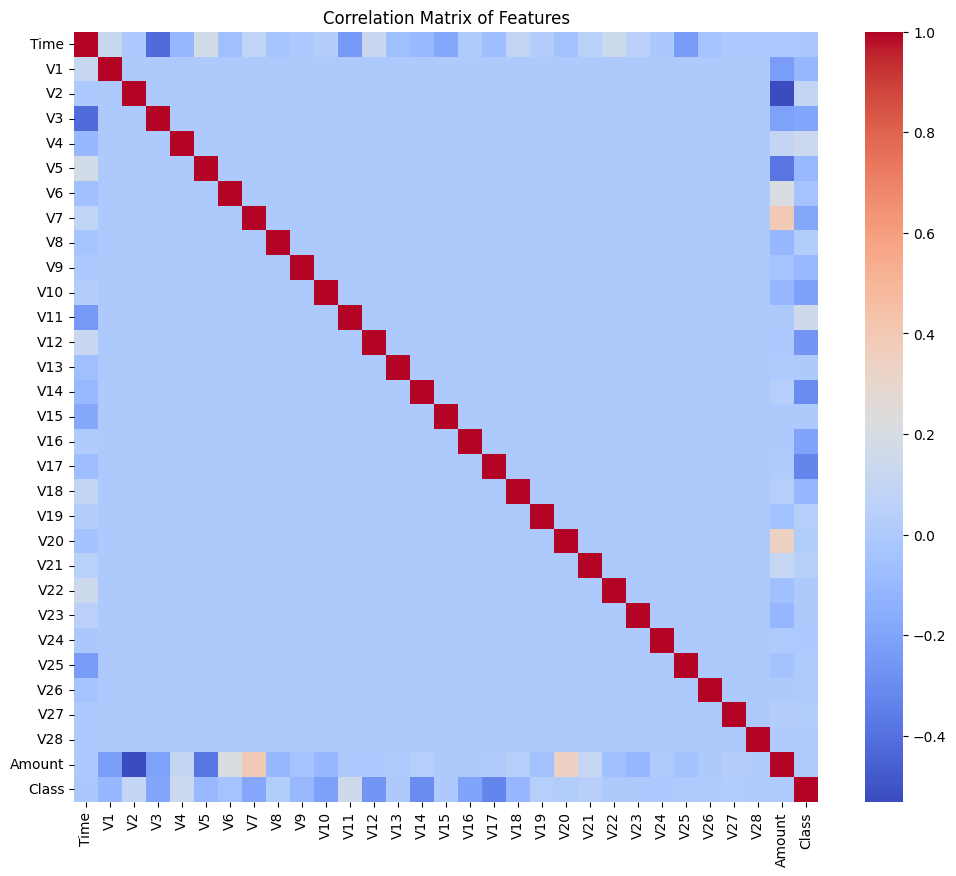

In [19]:

# b. Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


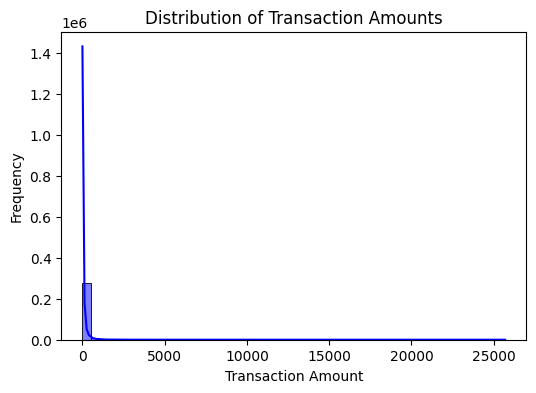

In [20]:

# c. Distribution of Transaction Amounts
plt.figure(figsize=(6, 4))
sns.histplot(df['Amount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


<ipython-input-21-3892ad19ab78>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df, palette='Set1')


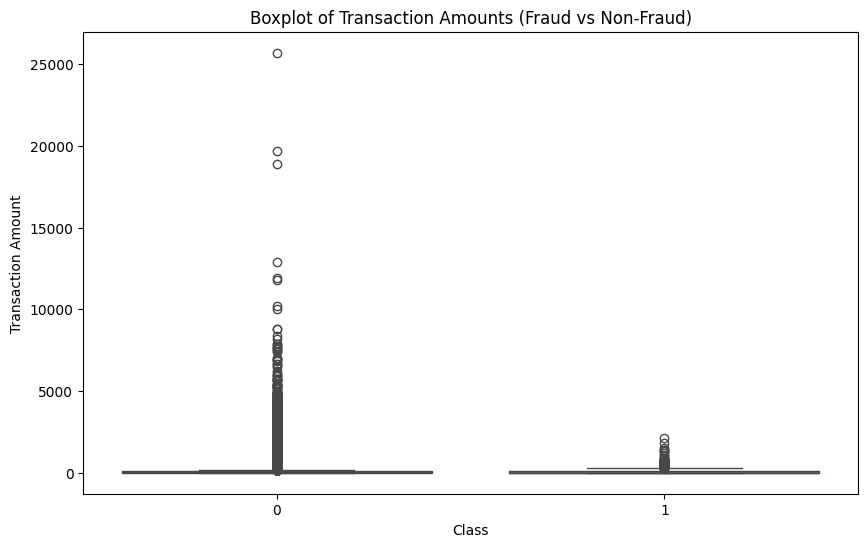

In [21]:

# d. Boxplot of Transaction Amounts (Fraud vs Non-Fraud)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df, palette='Set1')
plt.title('Boxplot of Transaction Amounts (Fraud vs Non-Fraud)')
plt.xlabel('Class')
plt.ylabel('Transaction Amount')
plt.show()


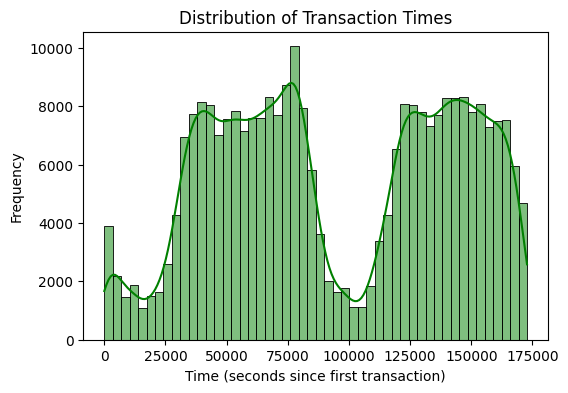

In [22]:

# e. Transaction Time Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['Time'], bins=50, kde=True, color='green')
plt.title('Distribution of Transaction Times')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# f. Pairplot of a Subset of Features
# To avoid clutter, select a subset of features
subset_features = ['V1', 'V2', 'Amount', 'Time', 'Class']
sns.pairplot(df[subset_features], hue='Class', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()